# Demo of fkptjax Calculations

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

### Prepare Inputs

In [3]:
import fkptjax.snapshot
import fkptjax.util

Load the default inputs included with the package:

In [4]:
snap = fkptjax.snapshot.load_snapshot()

A calculation requires the following physical and numerical parameters to be specified:

In [5]:
snap.print_params()

Input Parameters

Cosmology:
  Growth rate at k→0 (f0)                : 0.749238

Output k-grid (for computed KFunctions):
  Minimum k (kmin)                       : 0.001000 h/Mpc
  Maximum k (kmax)                       : 0.500000 h/Mpc
  Number of k points (Nk)                : 120

Numerical Integration:
  Quadrature steps for k-integration     : 300
  Gauss-Legendre points for Q-functions  : 10
  Gauss-Legendre points for R-functions  : 10

SPT Kernel Constants (LCDM):
  Kernel constant A (KA_LCDM)            : 1.000000
  Kernel constant Ap (KAp_LCDM)          : 0.000000
  Kernel constant CFD3 (KR1_LCDM)        : 1.000000
  Kernel constant CFD3' (KR1p_LCDM)      : 1.000000

Variance and Damping:
  Velocity dispersion σ²_v (sigma2v)     : 23.309617 (Mpc/h)²


You must also specify a linear matter power spectrum and its corresponding no-wiggles power:

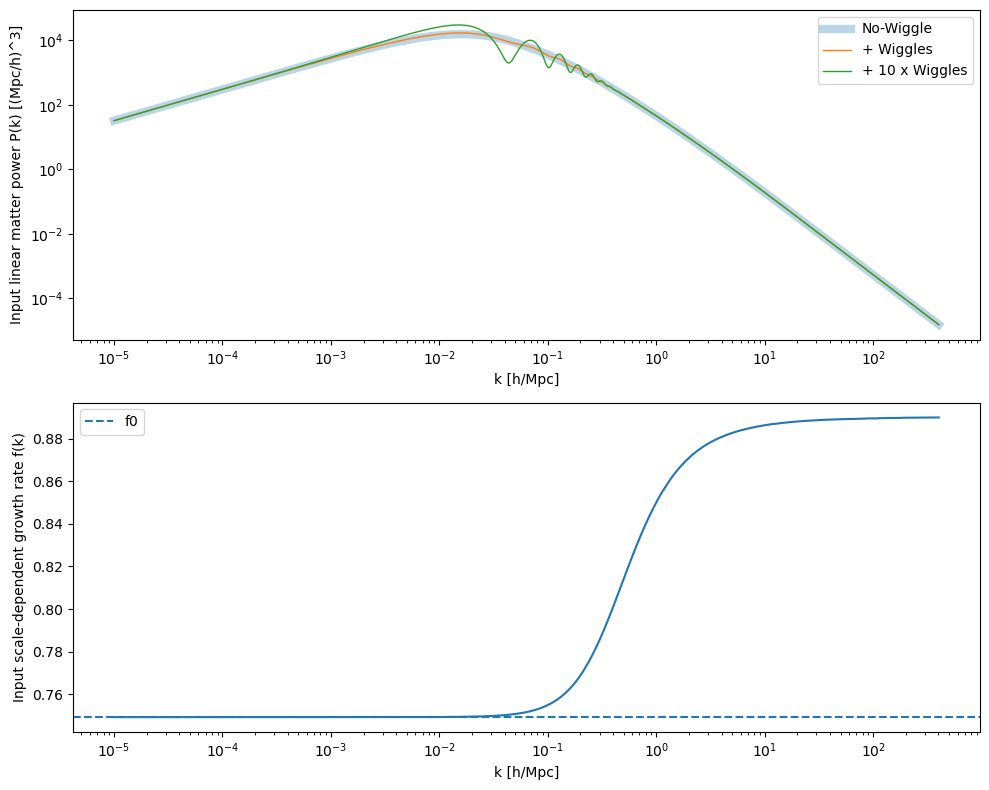

In [6]:
def plot_input_arrays(snap):

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    delta = snap.arrays.Pk_in - snap.arrays.Pk_nw_in
    ax[0].loglog(snap.arrays.k_in, snap.arrays.Pk_nw_in, lw=6, alpha=0.3, label='No-Wiggle')
    ax[0].loglog(snap.arrays.k_in, snap.arrays.Pk_in, lw=1, label='+ Wiggles')
    ax[0].loglog(snap.arrays.k_in, snap.arrays.Pk_nw_in + 10 * delta, lw=1, label='+ 10 x Wiggles')
    ax[0].set_xlabel('k [h/Mpc]')
    ax[0].set_ylabel('Input linear matter power P(k) [(Mpc/h)^3]')
    ax[0].legend()

    ax[1].semilogx(snap.arrays.k_in, snap.arrays.f_in)
    ax[1].axhline(snap.params.f0, ls='--', label='f0')
    ax[1].legend()
    ax[1].set_xlabel('k [h/Mpc]')
    ax[1].set_ylabel('Input scale-dependent growth rate f(k)')

    plt.tight_layout()
    plt.show()

plot_input_arrays(snap)

Prepare the initialization data required by the calculators below:

In [7]:
init_data = fkptjax.util.setup_kfunctions(
    k_in=snap.arrays.k_in,
    kmin=snap.params.kmin, kmax=snap.params.kmax, Nk=snap.params.Nk,
    nquadSteps=snap.params.nquadSteps, NQ=snap.params.NQ, NR=snap.params.NR)

### Select and Prepare Calculator

Choose between a pure-numpy and jax-accelerated implementation. The jax acceleration will use a GPU when available, but also speeds up a CPU-only calculation.

In [8]:
#from fkptjax.calculate_numpy import NumpyCalculator as Calculator
from fkptjax.calculate_jax import JaxCalculator as Calculator

One-time initialization of the calculator to establish the numerical parameters and k grids to use. This is relatively slow (few seconds) for the jax implementation. 

In [9]:

calculator = Calculator()
calculator.initialize(init_data)


### Evaluate K Functions

Evaluate k functions for each new input cosmology. There is no need to re-initialize when only the inputs to `evaluate()` are changing. The first call is relatively slow for the jax implementation due to JIT compilation.

In [10]:
kfuncs = calculator.evaluate(
    # cosmology
    Pk_in=snap.arrays.Pk_in, Pk_nw_in=snap.arrays.Pk_nw_in, fk_in=snap.arrays.f_in,
    # kernel constants
    A=snap.params.KA_LCDM, ApOverf0=snap.params.KAp_LCDM/snap.params.f0,
    CFD3=snap.params.KR1_LCDM, CFD3p=snap.params.KR1p_LCDM,
    # other parameters
    sigma2v=snap.params.sigma2v, f0=snap.params.f0)

Validate the calculated results against k functions calculated by the C code and stored in the snapshot:

In [11]:
fkptjax.util.validate_kfunctions(kfuncs, snap)

True

Time the evaluation code (not including the initial JIT overhead):

In [12]:
%timeit calculator.evaluate(snap.arrays.Pk_in, snap.arrays.Pk_nw_in, snap.arrays.f_in, snap.params.KA_LCDM, snap.params.KAp_LCDM/snap.params.f0, snap.params.KR1_LCDM, snap.params.KR1p_LCDM, snap.params.sigma2v, snap.params.f0)

25.7 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Plot K Functions

Plot the calculated one-loop pieces for density/velocity combinations (P22, P13):

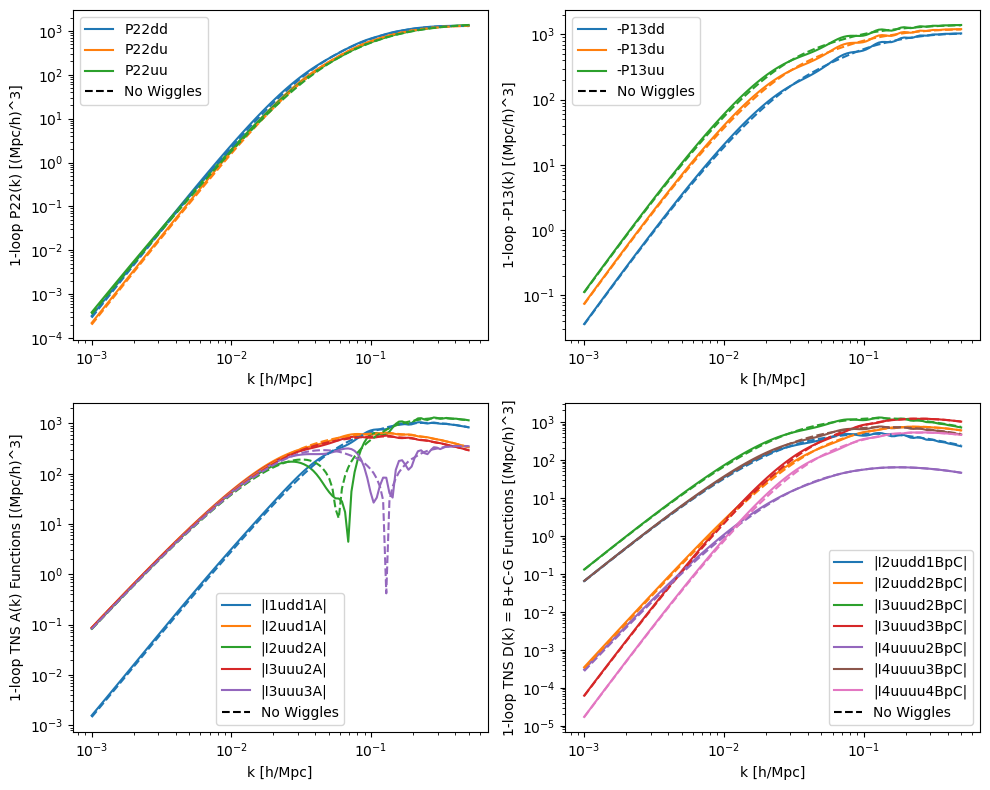

In [13]:
def plot_one_loop(k_out, kfuncs):

    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    for i, label in enumerate(('no-wiggles', 'wiggles')):
        ls = '-' if i == 0 else '--'
        ax[0,0].loglog(k_out, kfuncs.P22dd[i], c='C0', ls=ls, label=f'P22dd' if i == 0 else None)
        ax[0,0].loglog(k_out, kfuncs.P22du[i], c='C1', ls=ls, label=f'P22du' if i == 0 else None)
        ax[0,0].loglog(k_out, kfuncs.P22uu[i], c='C2', ls=ls, label=f'P22uu' if i == 0 else None)
        ax[0,1].loglog(k_out, -kfuncs.P13dd[i], c='C0', ls=ls, label=f'-P13dd' if i == 0 else None)
        ax[0,1].loglog(k_out, -kfuncs.P13du[i], c='C1', ls=ls, label=f'-P13du' if i == 0 else None)
        ax[0,1].loglog(k_out, -kfuncs.P13uu[i], c='C2', ls=ls, label=f'-P13uu' if i == 0 else None)
        ax[1,0].loglog(k_out, np.abs(kfuncs.I1udd1A[i]), c='C0', ls=ls, label=f'|I1udd1A|' if i == 0 else None)
        ax[1,0].loglog(k_out, np.abs(kfuncs.I2uud1A[i]), c='C1', ls=ls, label=f'|I2uud1A|' if i == 0 else None)
        ax[1,0].loglog(k_out, np.abs(kfuncs.I2uud2A[i]), c='C2', ls=ls, label=f'|I2uud2A|' if i == 0 else None)
        ax[1,0].loglog(k_out, np.abs(kfuncs.I3uuu2A[i]), c='C3', ls=ls, label=f'|I3uuu2A|' if i == 0 else None)
        ax[1,0].loglog(k_out, np.abs(kfuncs.I3uuu3A[i]), c='C4', ls=ls, label=f'|I3uuu3A|' if i == 0 else None)
        ax[1,1].loglog(k_out, np.abs(kfuncs.I2uudd1BpC[i]), c='C0', ls=ls, label=f'|I2uudd1BpC|' if i == 0 else None)
        ax[1,1].loglog(k_out, np.abs(kfuncs.I2uudd2BpC[i]), c='C1', ls=ls, label=f'|I2uudd2BpC|' if i == 0 else None)
        ax[1,1].loglog(k_out, np.abs(kfuncs.I3uuud2BpC[i]), c='C2', ls=ls, label=f'|I3uuud2BpC|' if i == 0 else None)
        ax[1,1].loglog(k_out, np.abs(kfuncs.I3uuud3BpC[i]), c='C3', ls=ls, label=f'|I3uuud3BpC|' if i == 0 else None)
        ax[1,1].loglog(k_out, np.abs(kfuncs.I4uuuu2BpC[i]), c='C4', ls=ls, label=f'|I4uuuu2BpC|' if i == 0 else None)
        ax[1,1].loglog(k_out, np.abs(kfuncs.I4uuuu3BpC[i]), c='C5', ls=ls, label=f'|I4uuuu3BpC|' if i == 0 else None)
        ax[1,1].loglog(k_out, np.abs(kfuncs.I4uuuu4BpC[i]), c='C6', ls=ls, label=f'|I4uuuu4BpC|' if i == 0 else None)
    for axi in ax.flatten():
        axi.loglog([], [], 'k--', label='No Wiggles')
        axi.set_xlabel('k [h/Mpc]')
        axi.legend()
    ax[0,0].set_ylabel('1-loop P22(k) [(Mpc/h)^3]')
    ax[0,1].set_ylabel('1-loop -P13(k) [(Mpc/h)^3]')
    ax[1,0].set_ylabel('1-loop TNS A(k) Functions [(Mpc/h)^3]')
    ax[1,1].set_ylabel('1-loop TNS D(k) = B+C-G Functions [(Mpc/h)^3]')

    plt.tight_layout()
    plt.show()

plot_one_loop(init_data.logk_grid, kfuncs)

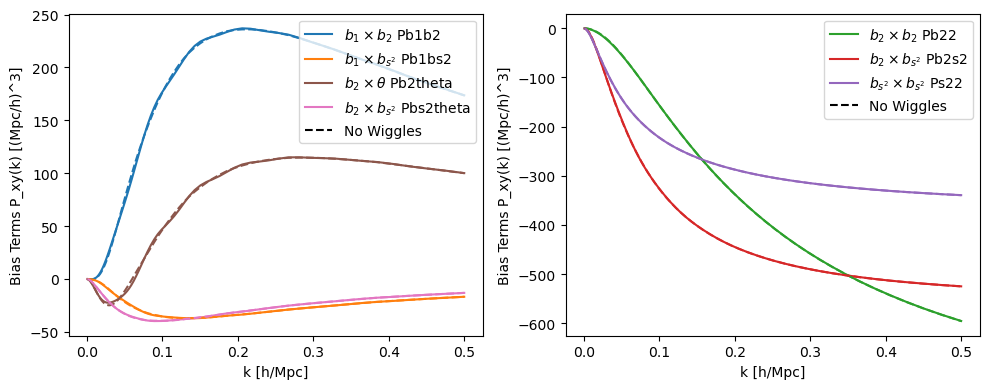

In [14]:
def plot_bias_terms(k_out, kfuncs):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    for i, label in enumerate(('no-wiggles', 'wiggles')):
        ls = '-' if i == 0 else '--'
        ax[0].plot(k_out, kfuncs.Pb1b2[i], c='C0', ls=ls, label='$b_1\\times b_2$ Pb1b2' if i == 0 else None)
        ax[0].plot(k_out, kfuncs.Pb1bs2[i], c='C1', ls=ls, label='$b_1\\times b_{s^2}$ Pb1bs2' if i == 0 else None)
        ax[1].plot(k_out, kfuncs.Pb22[i], c='C2', ls=ls, label='$b_2\\times b_2$ Pb22' if i == 0 else None)
        ax[1].plot(k_out, kfuncs.Pb2s2[i], c='C3', ls=ls, label='$b_2\\times b_{s^2}$ Pb2s2' if i == 0 else None)
        ax[1].plot(k_out, kfuncs.Ps22[i], c='C4', ls=ls, label='$b_{s^2}\\times b_{s^2}$ Ps22' if i == 0 else None)
        ax[0].plot(k_out, kfuncs.Pb2theta[i], c='C5', ls=ls, label='$b_2\\times \\theta$ Pb2theta' if i == 0 else None)
        ax[0].plot(k_out, kfuncs.Pbs2theta[i], c='C6', ls=ls, label='$b_2\\times b_{s^2}$ Pbs2theta' if i == 0 else None)

    for axi in ax:
        axi.plot([], [], 'k--', label='No Wiggles')
        axi.set_xlabel('k [h/Mpc]')
        axi.set_ylabel('Bias Terms P_xy(k) [(Mpc/h)^3]')
        axi.legend()

    plt.tight_layout()
    plt.show()

plot_bias_terms(init_data.logk_grid, kfuncs)